# Abstract

This notebook was made by Denise Biasio and Sarah Tew as part of the final project for Electronic Publishing and Digital Storytelling in fullfillment of an LM in Digital Humanities and Digital Knowledge from the University of Bologna. The name of this project is Wikigen. The webpage for this project is: https://sarahtew.github.io/wikigen/ and the github repository at: https://github.com/SarahTew/wikigen.

Wikigen is a data visualization project that analyzes Wikidata's description of art historians and how how those descriptions vary by gender. 

Wikidata is one of the largest free and open knowledge databases in the world. Launched in 2012, it now contains over 97 million items, over six million of them people. It appear across the internet—in Wikipedia info boxes, Google About panels, and is the first source of biographical information for many users.

While data is good, and open, linked data is better, data in context is best. Wikigen's context focus is the description of information, the translation of a person's life into Wikidata. 

Besides specific analysis of how Wikidata describes art historians, Wikigen also serves as a case study of Wikidata's gender-biases in descriptions of people with the same profession and highly similar academic and professional backgrounds.

## Project Aims
Wikigen seeks to better understand how art historians are described in Wikidata generally as well as how that description varies based on gender of the subject.

#### Key questions:
How does Wikidata describe art historians?

What kinds of properties does Wikidata use to describe art historians?

Does the gender of the subject affect how Wikidata describes them? 
If so, how? Where are the differences? What are the differences?

In [1]:
#imports
from SPARQLWrapper import SPARQLWrapper, JSON, GET, POST, CSV
import csv 
import seaborn as sns
import pandas as pd
import requests
import json
import ssl
import numpy as np
import pandas as pd
import string
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from PIL import Image
import plotly.express as px
import cv2
import pandas_profiling as pp
from celluloid import Camera

## Phase 1: Overview
We wanted to get an wide view of Wikidata's data on art historians. 

Our first query was simply the number of total number of art historians in Wikidata.

In [2]:
#Initial query that gets total number of art historians/those with art history subjobs in wikidata

ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"


General_Query = """SELECT (count(distinct ?human) as ?tot)
WHERE
{SERVICE wikibase:label {
     bd:serviceParam wikibase:language "en" .
   }
  ?human wdt:P31 wd:Q5
  ; wdt:P106/wdt:P279* wd:Q1792450 .
}
GROUP BY ?number
"""

# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(General_Query)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
results = sparql_wd.query().convert()

for result in results["results"]["bindings"]:
    total = result["tot"]["value"]
    NotDAH = (int(total))
    print(result)



{'tot': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '17765'}}


Then we broke down the total by gender. 

In [3]:
#Second query to break down art historians by gender

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

Gender_Query = """
SELECT ?genderLabel (count(distinct ?human) as ?number)
WHERE
{SERVICE wikibase:label {
     bd:serviceParam wikibase:language "en" .
   }
  ?human wdt:P31 wd:Q5
  ; wdt:P21 ?gender
  ; wdt:P106/wdt:P279* wd:Q1792450 .
}
GROUP BY ?genderLabel
"""

# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(Gender_Query)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
gender_results = sparql_wd.query().convert()


#manipulate the result
for result in gender_results["results"]["bindings"]:
    #gender = result["genderLabel"]["value"]
    #total_gender = result["number"]["value"]
    print(result["genderLabel"]["value"], result["number"]["value"])



male 11769
female 5887
non-binary 2


#### Manipulation of Data
Then we manipulated the data to get the percents of the total, including art historians without a declared gender (who are counted in the 1st query but not in the 2nd). Then we added the percents to the dataframe.

In [4]:
#Transform Values into int
men = int(gender_results["results"]["bindings"][0]['number']['value'])
women = int(gender_results["results"]["bindings"][1]['number']['value'])
nb = int(gender_results["results"]["bindings"][2]['number']['value'])

#Operations to find the percentage
Tot_gender = men + women + nb
Non_def = NotDAH - Tot_gender
pm = (men/NotDAH)*100
pf = (women/NotDAH)*100
pnb = (nb/NotDAH)*100
pnd = (Non_def/NotDAH)*100

#Trasform everything into a string again
string1 =str(NotDAH)
string2 =str(Non_def)
man1 = str(men)
fam1 = str(women)
nb1 = str(nb)
man2=str(round(pm,2))
fam2=str(round(pf,2))
nb2=str(round(pnb,2))
nd1=str(round(pnd,2))

#results
print ("On Wikidata there are" + " " + string1 + " " + "art historians.")
print (man1 + " " + "are" + " "+ "male." + " That is the" + " " + man2 + "%" + " " + "of the total.")
print (fam1 + " " + "are" + " "+ "female." " That is the" + " " + fam2 + "%" + " " + "of the total.")
print (nb1 + " " + "are" + " "+ "non-binary." + " That is the" + " " + nb2 + "%" + " " + "of the total.")
print (string2  + " " +  "are not defined by any gender." + " That is the" + " " + nd1 + "%" + " " + "of the total.")

On Wikidata there are 17765 art historians.
11769 are male. That is the 66.25% of the total.
5887 are female. That is the 33.14% of the total.
2 are non-binary. That is the 0.01% of the total.
107 are not defined by any gender. That is the 0.6% of the total.


In [5]:
df=pd.DataFrame()

genders= pd.Series(
    ["female","male","non-binary", "not declared"],
    name='genders'
)

percentages=Total_Property = pd.Series(
    [pf,pm,pnb,pnd],
    name='Properties'
)

df['Gender'] = genders
df['Percents'] = percentages.round(decimals = 2)


print(df)

         Gender  Percents
0        female     33.14
1          male     66.25
2    non-binary      0.01
3  not declared      0.60


### Visualization

The first visualization is a very simple one. We used this pie chart to visually break down the difference between genders and to underline the presence of non-binary and art historians which gender is not declared. 

In [25]:
fig = px.pie(df, values='Percents', names='Gender',color= 'Gender', color_discrete_map={'female': '#d49c7f', 'male': '#647494', 'not declared':'#887561', 'non-binary':'#b5a9ac'})

fig.update_layout(autosize=True)

fig.show()

fig.write_html("./general_overview.html")

#### Properties Overview
Then we wanted to look at the number of properties used to describe art historians. First, we ran a query for the number of distinct properties.

In [8]:
#query for distinct propery counts by gender
ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

# prepare the query
my_SPARQL_query = """
SELECT ?genderLabel (count(distinct ?property) as ?number)
WHERE
{SERVICE wikibase:label {
     bd:serviceParam wikibase:language "en" .
   }

  ?human wdt:P31 wd:Q5
  ; wdt:P21 ?gender
  ; ?property ?object
  ; wdt:P106/wdt:P279* wd:Q1792450 .

}

GROUP BY ?genderLabel
"""
# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(my_SPARQL_query)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
results = sparql_wd.query().convert()

# manipulate the result
for result in results["results"]["bindings"]:
    print(result["genderLabel"]["value"], result["number"]["value"])
print("🦐")


male 2678
female 1818
non-binary 235
🦐


#### Total number of declarations
Then we broadened the query to return the total number of declarations.

In [10]:
#Query for total number of declarations about art historians in Wikidata by gender

ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

# prepare the query
my_SPARQL_query = """
SELECT ?genderLabel (count(?property) as ?number)
WHERE
{SERVICE wikibase:label {
     bd:serviceParam wikibase:language "en" .
   }

  ?human wdt:P31 wd:Q5
  ; wdt:P21 ?gender
  ; ?property ?object
  ; wdt:P106/wdt:P279* wd:Q1792450 .

}

GROUP BY ?genderLabel
"""
# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(my_SPARQL_query)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
results = sparql_wd.query().convert()

# manipulate the result
for result in results["results"]["bindings"]:
    print(result["genderLabel"]["value"], result["number"]["value"])
print("🌮")



male 1205725
female 423183
non-binary 493
🌮


### Vizualization

##### Pixelated Images
Using the total number of properties, we wanted to get the average number of properties for the average art historian of each gender.

We used the metaphor of a portrait to visualize Wikidata's description of art historians. Using two paintings by Magritte as the base images, we created pixelized versions of them according to the number of properties used to describe male and female art historians.

In [11]:
#get number of properties
m_prop = int((results["results"]["bindings"][0]['number']['value']))
f_prop = int((results["results"]["bindings"][1]['number']['value']))
nb_prop = int((results["results"]["bindings"][2]['number']['value']))

#get average number of props per gender
avg_props_m = m_prop/men
avg_props_f = f_prop/women
avg_props_nb = nb_prop/nb

#divide by number of props per gender then by 2 to get number of pixels to be used in resizing
final_m = round((m_prop/men)/2)
final_f = round((f_prop/women)/2)
final_nb = round((nb_prop/nb)/2)

# Open images
#img_m = Image.open("man.jpg")
#img_f = Image.open("woman.jpg")

# Resize smoothly down to appropriate number of pixels
#img_m_sm = img_m.resize((final_m,final_m),resample=Image.BILINEAR)
#img_f_sm = img_f.resize((final_f, final_f),resample=Image.BILINEAR)

# Scale back up using NEAREST to original size
#result_m = img_m_sm.resize(img_m.size,Image.NEAREST)
#result_f = img_f_sm.resize(img_f.size,Image.NEAREST)

# Save pixelated versions
#result_m.save('result_m2.png')
#result_f.save('result_f2.png')

print("📸")

📸


##### Gifs
Then we turned the images into gifs that show the painting transforming into its pixelated version line by line to visualize Wikidata's descriptive translation of an indivudal into a portrait in data.

MovieWriter PillowWriter unavailable; using Pillow instead.


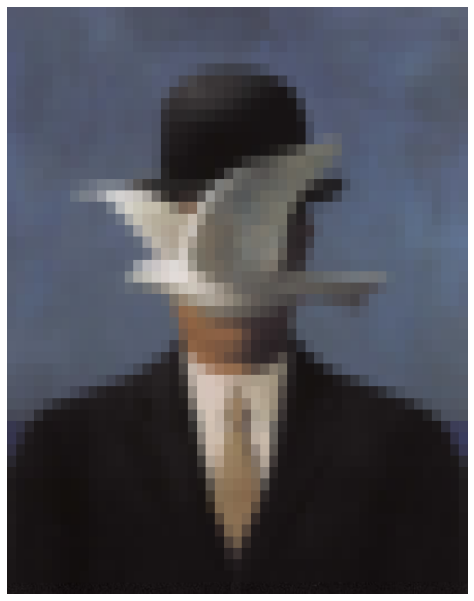

In [18]:
#This bulk of this code is from: https://dev.to/finloop/animating-two-images-transitioning-into-each-other-with-matplotlib-55bg
image1 = np.array(Image.open('man.jpg').convert('RGB'))
image2 = np.array(Image.open('result_m2.png').convert('RGB'))

fimage1 = image1.reshape((-1,3))
fimage2 = image2.reshape((-1,3))


def fade(shape, fimage1, fimage2, perc):
    i = int(fimage1.shape[0] * perc)
    return np.concatenate((fimage2[:i], fimage1[i:, :])).reshape(shape)
fig = plt.figure(figsize=(12, 10.8)) # Depends on aspect of your images
ax = plt.axes()
plt.margins(x=0)
plt.axis('off')

pic = ax.imshow(np.zeros(image1.shape)) # Create empty image of the same shape as image to plot
frames = 50 # Number of frames to generate

def init():
    pic.set_array(np.zeros(image1.shape))
    return [pic]

# This funtion generates i-th frame.
def animate(i):
    pic.set_array(fade(image1.shape, fimage1, fimage2, i/frames))
    return [pic]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, blit=True)

#save as gif
anim.save('animation6.gif', writer='PillowWriter', fps=150)


Making the woman gif

MovieWriter PillowWriter unavailable; using Pillow instead.


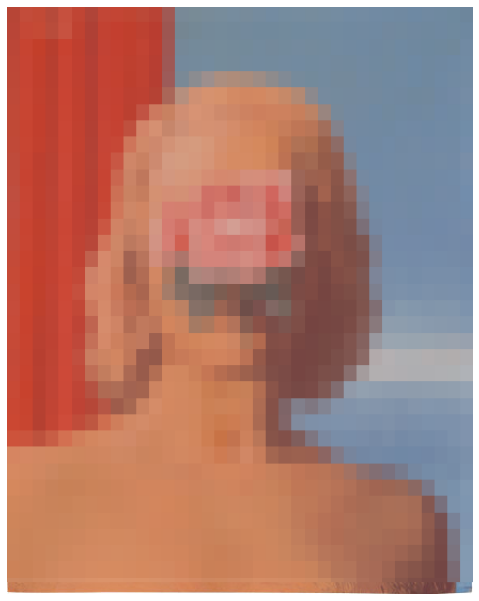

In [19]:
#This bulk of this code is from: https://dev.to/finloop/animating-two-images-transitioning-into-each-other-with-matplotlib-55b

image1 = np.array(Image.open('woman.jpg').convert('RGB'))
image2 = np.array(Image.open('result_f2.png').convert('RGB'))

fimage1 = image1.reshape((-1,3))
fimage2 = image2.reshape((-1,3))


def fade(shape, fimage1, fimage2, perc):
    i = int(fimage1.shape[0] * perc)
    return np.concatenate((fimage2[:i], fimage1[i:, :])).reshape(shape)
fig = plt.figure(figsize=(12, 10.8)) # Depends on aspect of your images
ax = plt.axes()
plt.margins(x=0)
plt.axis('off')

pic = ax.imshow(np.zeros(image1.shape)) # Create empty image of the same shape as image to plot
frames = 50 # Number of frames to generate

def init():
    pic.set_array(np.zeros(image1.shape))
    return [pic]

# This funtion generates i-th frame.
def animate(i):
    pic.set_array(fade(image1.shape, fimage1, fimage2, i/frames))
    return [pic]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, blit=True)

#save as gif
anim.save('animation5.gif', writer='PillowWriter', fps=150)


### Phase 2: Types of Properties
Next, we wanted to break down those properties into types to see if certain properties/types of properties appear more often for some genders over others.
#### Authority Properties
The first query is for how many art historians of each gender are linked to an external authority.


In [12]:

ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

# prepare the query
my_SPARQL_query = """
# Make a list of the most used authority control properties for people for art historians by gender
SELECT ?propertyLabel ?genderLabel ?count WHERE {
  {
    select distinct?gender ?propertyclaim (COUNT(*) AS ?count) where {
      ?item wdt:P106/wdt:P279* wd:Q1792450  .
      ?item wdt:P31 wd:Q5 .
      ?item wdt:P21 ?gender .
      ?item ?propertyclaim [] .
    } group by ?propertyclaim ?gender
  }
  ?property wikibase:propertyType wikibase:ExternalId .
  ?property wdt:P31 wd:Q19595382 .
  ?property wikibase:claim ?propertyclaim .
  SERVICE wikibase:label {            # ... include the labels
    bd:serviceParam wikibase:language "en" .
  }
} ORDER BY DESC (?count)
#LIMIT 100
"""
# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(my_SPARQL_query)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
results = sparql_wd.query().convert()

# manipulate the result
for result in results["results"]["bindings"]:
    print(result["propertyLabel"]["value"], result["genderLabel"]["value"], result["count"]["value"])
print("👻")
m_viaf=int(results["results"]["bindings"][0]['count']['value'])
f_viaf=int(results["results"]["bindings"][8]['count']['value'])


VIAF ID male 11560
ISNI male 9649
WorldCat Identities ID male 9532
Library of Congress authority ID male 8605
GND ID male 8481
NUKAT ID male 7837
Nationale Thesaurus voor Auteurs ID male 7196
Bibliothèque nationale de France ID male 5743
VIAF ID female 5436
NKCR AUT ID male 5085
Deutsche Biographie (GND) ID male 4951
PLWABN ID male 4281
ISNI female 4030
WorldCat Identities ID female 3666
Library of Congress authority ID female 3497
SHARE Catalogue author ID male 3428
GND ID female 3424
Vatican Library VcBA ID male 3134
Unione Romana Biblioteche Scientifiche ID male 3097
NUKAT ID female 2996
American Academy in Rome ID male 2936
IxTheo authority ID male 2774
NORAF ID male 2586
Open Library ID male 2408
Nationale Thesaurus voor Auteurs ID female 2370
Bibliothèque nationale de France ID female 2215
National Library of Israel J9U ID male 2145
abART person ID male 2089
Vatican Library ID (former scheme) male 2036
CONOR.SI ID male 1805
NKCR AUT ID female 1748
Kallías ID male 1572
Deutsche Bi

#### VIAF Visualization

VIAF was, by far, the most used ID for male and female art historians. We selected VIAF to serve as a representative example to create a simple bar chart showing the percentage of male and female art historians with VIAF ids.

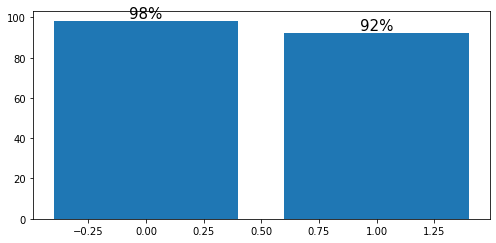

In [14]:
#Do not delete
#This is an inefficient way to set up the next bar chart but it doesn't work without it, or combined in the next cell
m_viaf_p = round(m_viaf/men * 100)
f_viaf_p = round(f_viaf/women * 100)

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

frequencies = [m_viaf_p, f_viaf_p]

plt.figure()

p1 = plt.bar(np.arange(len(frequencies)), frequencies)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate( "{}%".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=15)


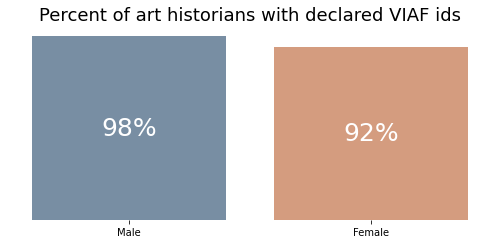

In [16]:
#Final vizualization for VIAF ids

m_viaf_p = round(m_viaf/men * 100)
f_viaf_p = round(f_viaf/women * 100)

x = ['Male', 'Female']
y = [m_viaf_p, f_viaf_p]
c = ["#788ea3", "#d49c7f"]
  
plt.bar(x, y, color=c)

plt.title("Percent of art historians with declared VIAF ids", fontsize=18)
for rect1 in p1:
    height = rect1.get_height()
    plt.annotate( "{}%".format(height),(rect1.get_x() + rect1.get_width()/2, height/2),ha="center",va="center",fontsize=25, color="white")

plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['left'].set_color('none')
plt.gca().spines['bottom'].set_color('none')
plt.yticks([])
plt.savefig('viaf.png', bbox_inches='tight',pad_inches = 0)


#### Visualization: Average number of linked authorities

We wanted to visualize the average number of external authorities per the average art historian of each gender. 

First made a query to get the total coutns by gender then we did some math to add the average to the dataframe.

In [18]:
#Query to get the total count of all authority properties by gender

ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

# prepare the query
my_SPARQL_query = """
# Make a list of the most used authority control properties for people for art historians by gender
#counting people rather than properties
SELECT ?propertyLabel ?genderLabel ?count WHERE {
  {
    select distinct?gender ?propertyclaim (COUNT(distinct(?item)) AS ?count) where {
      ?item wdt:P106/wdt:P279* wd:Q1792450  .
      ?item wdt:P31 wd:Q5 .
      ?item wdt:P21 ?gender .
      ?item ?propertyclaim [] .
    } group by ?propertyclaim ?gender
  }
  ?property wikibase:propertyType wikibase:ExternalId .
  ?property wdt:P31 wd:Q19595382 .
  ?property wikibase:claim ?propertyclaim .
  SERVICE wikibase:label {            # ... include the labels
    bd:serviceParam wikibase:language "en" .
  }
} ORDER BY DESC (?count)
"""
# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(my_SPARQL_query)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
auth_result = sparql_wd.query().convert()

# manipulate the result
#for result in auth_results["results"]["bindings"]:
    #print(result["propertyLabel"]["value"], result["genderLabel"]["value"], result["count"]["value"])

#Create csv file
with open('authorities.csv', mode='w', encoding="utf-8") as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['Authority', 'Gender', "Count"])
    for result in auth_result["results"]["bindings"]:
        my_writer.writerow([result["propertyLabel"]["value"], result["genderLabel"]["value"], result["count"]["value"].strip()])

# parse the csv into a dataframe
dfd = pd.read_csv("authorities.csv")

#sum the counts by gender
dff = dfd.groupby(["Gender"]).Count.sum().reset_index()
#drop nb
dff = dff.drop(dff.index[2])

#add colum for average
f_auth = dff.iat[0,1]
m_auth = dff.iat[1,1]
ff_auth = round(f_auth/women)
fm_auth = round(m_auth/men)
average = [ff_auth, fm_auth]
dff["average"] = average
dff.head()


,Gender,Count,average
0,female,51549,9
1,male,149190,13


To vizualize these averages we chose to use the Magritte paintings again. The number of images represents the average number of authorities the average art historian of each gender is linked to through Wikidata declarations.

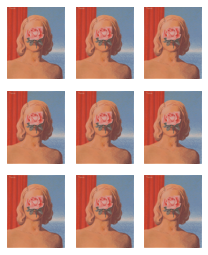

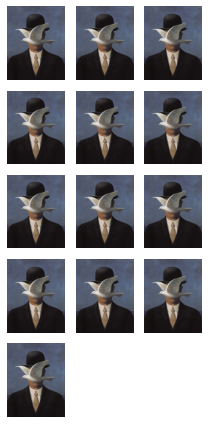

In [22]:
# code for displaying multiple images in one figure
 
ff_auth = round(f_auth/women)
fm_auth = round(m_auth/men)
    
def multiply_img (image_file, dest_file, number):
    # create figure
    i = number
    fig = plt.figure(figsize=(3, 6))
  
  
    # setting values to rows and column variables
    rows = 5
    columns = 3
  
    # reading images
    Image1 = cv2.imread(image_file)
    #converting color channels
    rgb_img = cv2.cvtColor(Image1, cv2.COLOR_BGR2RGB)
    
    # Adds a subplot at all positions
    while i > 0:
        fig.add_subplot(rows, columns, i)
        i = i-1
        # showing image
        plt.imshow(rgb_img)
        plt.axis('off')
    plt.savefig(dest_file)
 
multiply_img("woman.jpg", "auth_f.png", ff_auth)
multiply_img("man.jpg", "auth_m.png", fm_auth)


### Phase 3: Professions and Occupations

In this part we wanted to analyse another important property that is surely present in every art historian's Wikipedia page: work-related properties.

First we made a query that will give us the total number of jobs per gender.

In [13]:
ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

# prepare the query
number_jobs = """
SELECT ?genderLabel (COUNT(?job) AS ?count_job)
WHERE 
{ 

  ?human wdt:P21 ?gender
  ; wdt:P106 wd:Q1792450
  ; wdt:P106 ?job
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }

}
GROUP BY ?genderLabel
ORDER BY ?genderLabel
"""
# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(number_jobs)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
results = sparql_wd.query().convert()


### Data Manipulation

We manipulate data in order to obtain the avarage number of jobs pesent on an art historian Wikipedia page

In [14]:
#Create CSV

with open('overview_jobs.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    my_writer.writerow(["Gender", "Total Jobs"])
    for result in results["results"]["bindings"]:
        my_writer.writerow([result["genderLabel"]["value"], result["count_job"]["value"].strip()])
        

dfo = pd.read_csv("overview_jobs.csv")


Total= pd.Series(
    [women, men, nb],
    name='Total'
)

dfo['Total Art Historian'] = Total 



#avarage number of job per Art Historian by gender

avarage_job = dfo['Total Jobs']/dfo['Total Art Historian']

dfo['Avarage'] = avarage_job

dfo['Avarage']= dfo['Avarage'].round(decimals = 2)

print(dfo)


       Gender  Total Jobs  Total Art Historian  Avarage
0      female       11095                 5887     1.88
1        male       27574                11767     2.34
2  non-binary           7                    2     3.50


If we consider than in this avarage the job as Art Historian is included, as it is listed as job and respond to the property [wdt:106](https://www.wikidata.org/wiki/Property:P106), we can say that man tends to have at least another occupation to pair up with their work as Art Historian while for female the Art Historian job seems to be the main occupation. I decided to leave the non-binary results beause even thought the real number are tiny the avarage denote an effort form whoever entered those informations to describe in a very specific way these art historians.  

In [15]:
fig = px.bar(dfo, x='Gender', y='Avarage', title ="Avarege Job for each gender",color="Gender", color_discrete_map={'female': '#d49c7f', 'male': '#647494', 'non-binary':'#bdb2a5'})

fig.update_layout(showlegend=False, plot_bgcolor='white',autosize=True)

fig.show()

fig.write_html("./avarage_job.html")

 Now we wanted to discover what are the specific jobs per each gender.

<b>Top jobs for Male Art Historian<b>
   

In [16]:
#QUERY MALE
ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

# prepare the query
male_job_list = """

SELECT ?jobLabel (COUNT(?human) AS ?tot)

WHERE 
{ 
  ?human wdt:P21 wd:Q6581097
  ; wdt:P106 wd:Q1792450
  ; wdt:P106 ?job
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
GROUP BY ?jobLabel 
ORDER BY DESC(?tot)
LIMIT 21
"""

# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(male_job_list)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
male_job_list_result = sparql_wd.query().convert()


In [17]:

with open('male_jobs.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['Job', 'Total'])
    for result in male_job_list_result ["results"]["bindings"]:
        my_writer.writerow([result["jobLabel"]["value"], result["tot"]["value"].strip()])
        


# parse the csv into a dataframe
df = pd.read_csv("male_jobs.csv")

# eliminate the 'art historian' row
df= df.drop([0])

percentage = (df['Total']/Tot_gender)*100

    
df['Percentage']= percentage

df['Percentage']= df['Percentage'].round(decimals = 2)

# print the first 20 rows
df.head(20)


            
            

,Job,Total,Percentage
1,university teacher,1804,10.22
2,writer,1057,5.99
3,archaeologist,1032,5.85
4,historian,1003,5.68
5,painter,642,3.64
6,curator,554,3.14
7,art critic,500,2.83
8,exhibition curator,415,2.35
9,journalist,386,2.19
10,teacher,377,2.14


<b>Visualization Male Job List<b>

In [18]:
fig = px.bar(df, x="Percentage", y="Job", orientation='h', color="Job",
             color_discrete_map={"university teacher": '#647494',"historian":'#647494', "exhibition curator": '#647494',
                                "curator": '#647494', "writer":'#647494', "archaeologist":'#647494',"art critic":'#647494',
                                 "journalist":'#647494', "author":'#647494',"translator":'#647494',"poet":'#647494',
                                 "opinion journalist":'#647494',"museum director":'#647494',"painter":'#647494',"politician":'#647494',
                                "anthropologist":'#647494', "architect":'#647494', "teacher":'#647494',"architectural historian":'#647494', "art collector":'#647494'}, title="Male Job List")


fig.update_layout(showlegend=False,plot_bgcolor='white',autosize=True)

#fig.update_xaxes(range=(1, 5), constrain='domain')

fig.show()

fig.write_html("./male_jobs.html")

<b>Top jobs for female art historian<b>

In [19]:
ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

# prepare the query
female_job_list = """

SELECT ?jobLabel (COUNT(?human) AS ?tot)

WHERE 
{ 
  ?human wdt:P21 wd:Q6581072 
  ; wdt:P106 wd:Q1792450
  ; wdt:P106 ?job
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
GROUP BY ?jobLabel 
ORDER BY DESC(?tot)
LIMIT 21
"""

# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(female_job_list)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
female_job_list_result = sparql_wd.query().convert()



In [20]:
#create CSV
with open('female_jobs.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['Job', 'Total'])
    for result in female_job_list_result ["results"]["bindings"]:
        my_writer.writerow([result["jobLabel"]["value"], result["tot"]["value"].strip()])
        
# parse the csv into a dataframe
df = pd.read_csv("female_jobs.csv")

# eliminate the 'art historian' row
df= df.drop([0])

# print the first 10 rows
df.head(20)

percentage = (df['Total']/Tot_gender)*100

    
df['Percentage']= percentage

df['Percentage']= df['Percentage'].round(decimals = 2)

# print the first 20 rows
df.head(20)

,Job,Total,Percentage
1,university teacher,489,2.77
2,historian,418,2.37
3,exhibition curator,391,2.21
4,curator,385,2.18
5,writer,380,2.15
6,archaeologist,189,1.07
7,art critic,164,0.93
8,journalist,139,0.79
9,author,117,0.66
10,translator,114,0.65


### Visualization 

In [21]:

fig = px.bar(df, x="Percentage", y="Job", orientation='h', color= 'Job', 
             color_discrete_map={"university teacher": '#d49c7f',"historian":'#d49c7f', "exhibition curator": '#d49c7f',
                                "curator": '#d49c7f', "writer":'#d49c7f', "archaeologist":'#d49c7f',"art critic":'#d49c7f',
                                 "journalist":'#d49c7f', "author":'#d49c7f',"translator":'#d49c7f',"teacher":'#d49c7f',
                                 "opinion journalist":'#d49c7f',"museum director":'#d49c7f',"painter":'#d49c7f',"professor":'#d49c7f',
                                "museologist":'#d49c7f', "librarian":'#d49c7f', "artist":'#d49c7f',"academic":'#d49c7f', "researcher":'#d49c7f'}, title="Female Job List")

fig.update_layout(showlegend=False, plot_bgcolor='white',autosize=True)
                  


fig.show()

fig.write_html("./female_jobs.html")

<b>Top jobs for non binary art historians<b>

Even though this query is numerically and visually speaking usless, as this data can be see as outliers, I decided to leave it here as a part of this exploratory analysis.

In [22]:
#QUERY NON BINARY

ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

# prepare the query
non_binary_job_list = """

SELECT ?jobLabel (COUNT(?human) AS ?tot)

WHERE 
{ 
  ?human wdt:P21 wd:Q48270 
  ; wdt:P106 wd:Q1792450
  ; wdt:P106 ?job
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
GROUP BY ?jobLabel 
ORDER BY DESC(?tot)
LIMIT 21
"""

# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(non_binary_job_list)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
non_binary_job_list_result = sparql_wd.query().convert()


with open('non_binary_jobs.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['Job', 'Total'])
    for result in non_binary_job_list_result ["results"]["bindings"]:
        my_writer.writerow([result["jobLabel"]["value"], result["tot"]["value"].strip()])
        


# parse the csv into a dataframe
df = pd.read_csv("non_binary_jobs.csv")

# print the first 10 rows
df.head(10)





,Job,Total
0,writer,1
1,professor,1
2,art historian,1
3,journalist,1
4,film critic,1
5,literary critic,1
6,essayist,1


### Phase 4: Academic Information

From the job analysis it is clear that art historian ,both man and women, tend to have jobs that gravitates around the academic universe. Additionally, in the female art historian job list we can find several teaching-related jobs, namely: teacher, professor, academic and researcher. In this section we will take four different types of education-related properties to see how much academic qualifications is present in art historians wikidata page

First of all we isolate all the total number of education-related jobs with this Teaching_Job query. 

In [24]:
ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

# prepare the query
Teaching_Job = """SELECT ?genderLabel (COUNT(?job) AS ?tot)

WHERE 
{ 
  ?human wdt:P21 ?gender 
  ; wdt:P106 wd:Q1792450
  ; wdt:P106 ?job.  
  ?job wdt:P425 wd:Q352842 
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
GROUP BY ?genderLabel
ORDER BY ?genderLabel
"""

# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(Teaching_Job)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
Teaching_Job = sparql_wd.query().convert()

#Create csv file
with open('teaching_job.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['Art Historian Gender', 'Teaching Job Total'])
    for result in Teaching_Job["results"]["bindings"]:
        my_writer.writerow([result["genderLabel"]["value"],result["tot"]["value"].strip()])

# parse the csv into a dataframe
teaching = pd.read_csv("teaching_job.csv")

# print 
teaching.head()


,Art Historian Gender,Teaching Job Total
0,female,609
1,male,2184


Then we perfom the Academic_Degree query to get the total number of art historians that have a degree listed on their Wikidata page using the porperty [wdt:512](https://www.wikidata.org/wiki/Property:P512) associated with the academic degree a the person holds.

In [25]:
ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

# prepare the query
Academic_Degree = """
SELECT ?genderLabel (COUNT(?human) as ?degreecount)
WHERE
{ 
  ?human wdt:P31 wd:Q5
  ; wdt:P21 ?gender
  ; wdt:P106/wdt:P279* wd:Q1792450 
  ; wdt:P512 ?degree.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}

GROUP BY (?genderLabel)
ORDER BY ?genderLabel
"""

# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(Academic_Degree)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
Academic_Degree_result = sparql_wd.query().convert()

#Create csv file
with open('degree.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['Art Historian Gender', 'Degree'])
    for result in Academic_Degree_result["results"]["bindings"]:
        my_writer.writerow([result["genderLabel"]["value"],result["degreecount"]["value"].strip()])

# parse the csv into a dataframe
dfd = pd.read_csv("degree.csv")

dfd=dfd.drop(2)

tot_degree=dfd["Degree"]

dfd["Degree"]= ((dfd['Degree']/dfo['Total Art Historian'])*100).round(decimals = 2)

#print(tot_degree) 
dfd.head()


,Art Historian Gender,Degree
0,female,7.88
1,male,7.72


We proceed with the Doctorate query to see how many art historian are doctorates. 

In [26]:
ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

# prepare the query
Doctorate = """SELECT ?genderLabel (COUNT(?human) as ?doctoratecount)
WHERE
{ 
  ?human wdt:P31 wd:Q5
  ; wdt:P21 ?gender
  ; wdt:P106/wdt:P279* wd:Q1792450 
  ; wdt:P512 ?degree.
  ?degree wdt:P279 wd:Q3529618
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}

GROUP BY (?genderLabel)
ORDER BY ?genderLabel
"""

# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(Doctorate)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
Doctorate_result = sparql_wd.query().convert()

#Create csv file
with open('doctorate.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['Art Historian Gender', 'Doctorate Total'])
    for result in Doctorate_result["results"]["bindings"]:
        my_writer.writerow([result["genderLabel"]["value"],result["doctoratecount"]["value"].strip()])

# parse the csv into a dataframe
dfdd = pd.read_csv("doctorate.csv")

# print 
dfdd.head()


,Art Historian Gender,Doctorate Total
0,female,125
1,male,371


Lastly we computed the Professor query to obtain the total number of art historian that are officialy liked by VIAF to an univerity page as professors. 

In [27]:
ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

# prepare the query
Professor = """SELECT ?genderLabel (COUNT(?property) AS ?count) 
WHERE
{
      ?item wdt:P106/wdt:P279* wd:Q1792450  .
      ?item wdt:P31 wd:Q5 .
      ?item wdt:P21 ?gender .
      ?item ?propertyclaim [] .
      ?property wdt:P31 wd:Q107211056.
    ?property wikibase:claim ?propertyclaim .
  
      SERVICE wikibase:label {            # ... include the labels
    bd:serviceParam wikibase:language "en" .
  }
 }

GROUP BY ?genderLabel
ORDER BY ?genderLabel
"""

# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(Professor)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
Professor_result = sparql_wd.query().convert()

#Create csv file
with open('professor.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['Art Historian Gender', 'Professor Total'])
    for result in Professor_result["results"]["bindings"]:
        my_writer.writerow([result["genderLabel"]["value"],result["count"]["value"].strip()])

# parse the csv into a dataframe
dfp = pd.read_csv("professor.csv")

# print 
dfp.head()

,Art Historian Gender,Professor Total
0,female,25
1,male,200


<b>Manipulate Data<b>

It's now time to merge all the previous csv result files into an one dataframe to work on the visualization. 

In [28]:
doctorate=((dfdd['Doctorate Total']/dfo['Total Art Historian'])*100).round(decimals = 2)

professor=((dfp['Professor Total']/dfo['Total Art Historian'])*100).round(decimals = 2)

teaching =((teaching['Teaching Job Total']/dfo['Total Art Historian'])*100).round(decimals = 2)

dfd['Doctorate']= doctorate
dfd['VIAF Professor']= professor
dfd['Teaching Job']= teaching


print(dfd)

  Art Historian Gender  Degree  Doctorate  VIAF Professor  Teaching Job
0               female    7.88       2.12            0.42         10.34
1                 male    7.72       3.15            1.70         18.56


<b>Visualization<b>
    
With this visalization we wanted to comapre these four values by gender but also onve with the other. We can 

In [45]:
dfd1 = dfd.set_index('Art Historian Gender')
dfd1.columns.name = "Values"


fig = px.bar(dfd1, facet_col="Values", color=dfd1.index, color_discrete_map={'female': '#d49c7f', 'male': '#647494'})
fig.update_layout(autosize=True, plot_bgcolor='white')

fig.update_xaxes(ticklabelposition="inside top", title=None)


fig.show()

fig.write_html("./academic_info.html")


### Phase 5: Personal Relationships
First we wanted to know what Wikidata considered a personal relationship and how frequently each type appeared across genders.


In [47]:
from SPARQLWrapper import SPARQLWrapper, JSON
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

# prepare the query
my_SPARQL_query = """
# Make a list of the most used authority control properties for people for art historians by gender
SELECT ?propertyLabel ?genderLabel ?count WHERE {
  {
    select distinct?gender ?propertyclaim (COUNT(*) AS ?count) where {
      ?item wdt:P106/wdt:P279* wd:Q1792450  .
      ?item wdt:P31 wd:Q5 .
      ?item wdt:P21 ?gender .
      ?item ?propertyclaim [] .
    } group by ?propertyclaim ?gender
  }
  #?property wikibase:propertyType wikibase:ExternalId .
  ?property wdt:P31 wd:Q22964231 .
  ?property wikibase:claim ?propertyclaim .
  SERVICE wikibase:label {            # ... include the labels
    bd:serviceParam wikibase:language "en" .
  }
} ORDER BY DESC (?count)
#LIMIT 100
"""
# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(my_SPARQL_query)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
results = sparql_wd.query().convert()

# manipulate the result
for result in results["results"]["bindings"]:
    print(result["propertyLabel"]["value"], result["genderLabel"]["value"], result["count"]["value"])
print("👶")

child male 800
father male 738
sibling male 626
spouse male 593
spouse female 382
father female 243
mother male 214
child female 163
relative male 157
sibling female 133
mother female 103
relative female 40
number of children male 30
unmarried partner male 23
number of children female 16
unmarried partner female 4
stepparent male 2
godparent male 1
godparent female 1
number of children non-binary 1
👶


Then, we made another query to total all relationship types by gender.

In [48]:
from SPARQLWrapper import SPARQLWrapper, JSON
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

# prepare the query
my_SPARQL_query = """
select ?keyLabel  (count(*) as ?count) where { 
    ?item wdt:P106/wdt:P279* wd:Q1792450  .
      ?item wdt:P31 wd:Q5 .
      ?item wdt:P21 ?gender .
      ?item ?propertyclaim [] .
      ?property wikibase:claim ?propertyclaim .
      ?property wdt:P31 wd:Q22964231 .
  SERVICE wikibase:label {            # ... include the labels
    bd:serviceParam wikibase:language "en" .
  }

    bind (coalesce(?totals, ?gender) as ?key)
} group by ?keyLabel
"""
# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(my_SPARQL_query)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
results = sparql_wd.query().convert()

# manipulate the result
for result in results["results"]["bindings"]:
    print(result["keyLabel"]["value"], result["count"]["value"])
print("🍕")

prm = int(results["results"]["bindings"][0]['count']['value'])
prf = int(results["results"]["bindings"][1]['count']['value'])
prnb = int(results["results"]["bindings"][2]['count']['value'])

male 3184
female 1085
non-binary 1
🍕


Then we did some basic math to get the average number of personal declartions for male and female art historians. However, since the percentage of men and women with personal relationships was declared was relatively small, the numbers were not very meaningful.

In [49]:

#basic math to get average number of declared personal relationships per art historian of each gender
prmf = prm/men
prff = prf/women

print("average number of personal relationships declared by gender")
print("male", prmf)
print("female", prff)

average number of personal relationships declared by gender
male 0.27058723548907965
female 0.18430439952437574


So we decided to focus on art historians with at least one personal relationship declaration. We made a query to get the total nubmer of distinct individuals of each gender having at least one personal relationship declaration.

In [50]:
#query for number of total number of individuals with any declared personal relationship by gender
ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

# prepare the query
my_SPARQL_query = """
select ?keyLabel  (count(distinct(?item)) as ?count) where { 
    ?item wdt:P106/wdt:P279* wd:Q1792450  .
      ?item wdt:P31 wd:Q5 .
      ?item wdt:P21 ?gender .
      ?item ?propertyclaim [] .
      ?property wikibase:claim ?propertyclaim .
      ?property wdt:P31 wd:Q22964231 .
  SERVICE wikibase:label {            # ... include the labels
    bd:serviceParam wikibase:language "en" .
  }

    bind (coalesce(?totals, ?gender) as ?key)
} group by ?keyLabel
"""
# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(my_SPARQL_query)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
results = sparql_wd.query().convert()

# manipulate the result
for result in results["results"]["bindings"]:
    print(result["keyLabel"]["value"], result["count"]["value"])
print("😗")

prm_indv = int(results["results"]["bindings"][0]['count']['value'])
prf_indv = int(results["results"]["bindings"][1]['count']['value'])
prnb_indv = int(results["results"]["bindings"][2]['count']['value'])

male 1558
female 607
non-binary 1
😗


#### Vizualization
Our first visualization was to show how large (or small) this group of art historian with at least one personal relationship declared in Wikidata was in a simple bar graph.

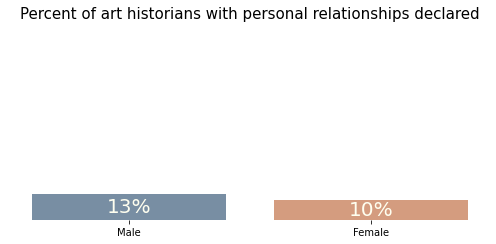

In [51]:
per_prm = round(prm_indv/men*100)
per_prf = round(prf_indv/women*100)

import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

frequencies = [per_prm, per_prf]

plt.figure()

p1 = plt.bar(np.arange(len(frequencies)), frequencies)

# code
import numpy as np
import matplotlib.pyplot as plt

 
# Marks of RAM in different subjects out of 100.
x = ['Male', 'Female']
y = [per_prm, per_prf]
c= c = ["#788ea3", "#d49c7f"]
  
p1 = plt.bar(x, y, color=c)

plt.title("Percent of art historians with personal relationships declared", fontsize=15)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate( "{}%".format(height),(rect1.get_x() + rect1.get_width()/2, height/2),ha="center",va="center", fontsize=20, color="#FFFFF0")

plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['left'].set_color('none')
plt.gca().spines['bottom'].set_color('none')
plt.ylim(0, 100)

plt.yticks([])
plt.savefig('pers_rel.png')

Because these percents were small, we decided to focus on the subgroup of art hsitorians with at least one personal realtionship declared and compare how often the properties appeared across genders. So, we counted the number of distinct art historians having each relationship.

In [52]:
#Query for total number of all distinct individuals and the type of relationship they have
from SPARQLWrapper import SPARQLWrapper, JSON
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

# prepare the query
my_SPARQL_query = """
SELECT ?propertyLabel ?genderLabel ?count WHERE {
  {
    select distinct?gender ?propertyclaim (COUNT(distinct?item) AS ?count) where {
      ?item wdt:P106/wdt:P279* wd:Q1792450  .
      ?item wdt:P31 wd:Q5 .
      ?item wdt:P21 ?gender .
      ?item ?propertyclaim [] .
    } group by ?propertyclaim ?gender
  }
  #?property wikibase:propertyType wikibase:ExternalId .
  ?property wdt:P31 wd:Q22964231 .
  ?property wikibase:claim ?propertyclaim .
  SERVICE wikibase:label {            # ... include the labels
    bd:serviceParam wikibase:language "en" .
  }
} ORDER BY DESC (?count)
"""
# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(my_SPARQL_query)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
results_pers_rels = sparql_wd.query().convert()

# manipulate the result
for result in results_pers_rels["results"]["bindings"]:
    print(result["propertyLabel"]["value"], result["genderLabel"]["value"], result["count"]["value"])
print("👪")

father male 722
spouse male 527
child male 519
sibling male 430
spouse female 357
father female 238
mother male 212
relative male 104
child female 104
mother female 102
sibling female 100
number of children male 30
relative female 28
unmarried partner male 22
number of children female 16
unmarried partner female 4
stepparent male 2
godparent male 1
godparent female 1
number of children non-binary 1
👪


Then we prepared a dataframe for visualization. We removed the data about non-binary art historians since there was too little data to analyze them in a meaninful way throughout this project. We also removed stepparent and godparents because the numbers were too small and cluttered the graph without adding much meaning.

In [53]:
#Percentage of art historians with personal relationships declared having each type of property
#This dataframe was very difficult to work with: 
#I don't know why but it only ran things in 3s which is why the code is duplicated

with open('pers_relationships.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['Relationship', 'Gender','Count'])
    for result in results_pers_rels ["results"]["bindings"]:
        my_writer.writerow([result["propertyLabel"]["value"], result["genderLabel"]["value"], result["count"]["value"].strip()])
        

# parse the csv into a dataframe
df = pd.read_csv("pers_relationships.csv")

# eliminate unwanted rows
df= df.drop([19])
df= df.drop([18])
df=df.drop([17])
df=df.drop([16])
percent_list = []

i=0

for row in df: #adds first 3 rows
    if df.at[i, 'Gender']=="female":
        percent_list.append(round(df.at[i,'Count']/prf_indv*100, 2))     
        i = i+1
               
    if df.at[i, 'Gender']=="male":
        percent_list.append(round(df.at[i,'Count']/prm_indv*100, 2))
        bb=df.at[i, 'Count']
        i = i+1 
    
for row in df: #adds second 3 rows
    if (df.at[i, 'Gender'])=="male":
        percent_list.append(round(df.at[i,'Count']/prm_indv*100, 2))
        i = i+1 
    if df.at[i, 'Gender']=="female":
        percent_list.append(round(df.at[i,'Count']/prf_indv*100, 2))      
        i = i+1 
        
for row in df: #adds third three rows
    if (df.at[i, 'Gender'])=="male":
        percent_list.append(round(df.at[i,'Count']/prm_indv*100, 2))
        i=i+1
    if df.at[i, 'Gender']=="female":
        percent_list.append(round(df.at[i,'Count']/prf_indv*100, 2))     
        i=i+1

for row in df: #adds 4th three rows
    if (df.at[i, 'Gender'])=="male":
        percent_list.append(round(df.at[i,'Count']/prm_indv*100, 2))
        i=i+1
    if df.at[i, 'Gender']=="female":
        percent_list.append(round(df.at[i,'Count']/prf_indv*100, 2))     
        i=i+1
        


df["percent"]=percent_list
print(df.head(20))


          Relationship  Gender  Count  percent
0               father    male    722    46.34
1               spouse    male    527    33.83
2                child    male    519    33.31
3              sibling    male    430    27.60
4               spouse  female    357    58.81
5               father  female    238    39.21
6               mother    male    212    13.61
7             relative    male    104     6.68
8                child  female    104    17.13
9               mother  female    102    16.80
10             sibling  female    100    16.47
11  number of children    male     30     1.93
12            relative  female     28     4.61
13   unmarried partner    male     22     1.41
14  number of children  female     16     2.64
15   unmarried partner  female      4     0.66


To visualize this data we chose a grouped bar plot showing the percentage of male and female art historians within the subgroup of those who had at least one personal relationship declared having each type of relatinoship.

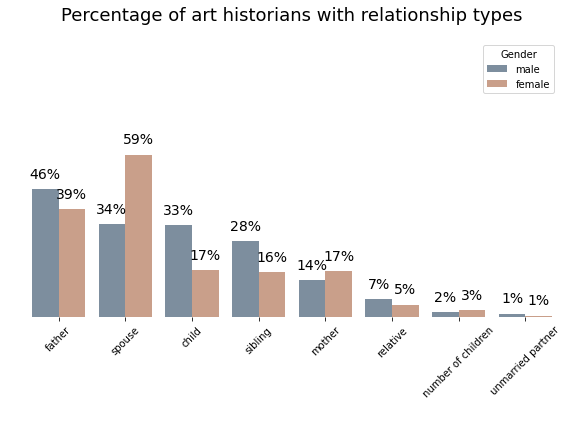

In [54]:
# Importing the dataset
  
data_df = df
palette = {'male': "#788ea3", 'female': "#d49c7f"}

# code to plot a simple grouped barplot
plt.figure(figsize=(8, 6))
splot = sns.barplot(x="Relationship", y="percent", hue="Gender",
                    data=data_df, palette= palette)
  
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = 20  # pad is in points...

plt.ylabel("Percent", size=14, color="none")
plt.xlabel("Relationship", size=14, color="none")
title=plt.title("Percentage of art historians with relationship types", size=18)
plt.gca().spines['bottom'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['left'].set_color('none')
plt.yticks([])

plt.xticks(rotation=45)
for p in splot.patches:
    splot.annotate(format(round(p.get_height()), '.0f')+"%",
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   size=14,
                   xytext=(0, 15),
                   textcoords='offset points')
  

plt.ylim(0, 100)
plt.savefig('percent_rels.png')


### Phase 6: Professional Relationships 

The last step in our analysis was to look at professional relationships, essentially in the same way we looked at the personal ones. We wanted to know what percentage of art hsitorians had these relationships declared and how the specific types of relationships broke down across genders.

First we just looked at educational properties.


In [55]:
ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

# prepare the query
my_SPARQL_query = """
SELECT ?property ?propertyLabel ?genderLabel ?count WHERE {
  {
    select distinct?gender ?propertyclaim (COUNT(*) AS ?count) where {
      ?item wdt:P106/wdt:P279* wd:Q1792450  .
      ?item wdt:P31 wd:Q5 .
      ?item wdt:P21 ?gender .
      ?item ?propertyclaim [] .
    } group by ?propertyclaim ?gender
  }
  #?property wikibase:propertyType wikibase:ExternalId .
  ?property wdt:P31 wd:Q22984450.
  ?property wdt:P31 wd:Q18608871.
  ?property wikibase:claim ?propertyclaim .
  SERVICE wikibase:label {            # ... include the labels
    bd:serviceParam wikibase:language "en" .
  }
} ORDER BY DESC (?count)
"""
# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(my_SPARQL_query)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
results = sparql_wd.query().convert()

# manipulate the result
for result in results["results"]["bindings"]:
    print(result["propertyLabel"]["value"], result["genderLabel"]["value"], result["count"]["value"])
print("🍓")

educated at male 5439
educated at female 2817
academic degree male 917
academic degree female 465
student of male 450
student male 423
doctoral student male 254
doctoral advisor male 210
doctoral advisor female 111
professorship male 83
student of female 79
academic thesis male 60
academic major male 52
doctoral student female 45
professorship female 22
academic thesis female 22
student female 20
academic appointment female 12
academic major female 9
academic appointment male 9
educated at non-binary 5
doctoral student non-binary 5
academic degree non-binary 3
academic appointment non-binary 1
🍓


We wanted to limit the properties to only those that were about education and about other humans. Using Wikidata pages for art historians, we found a combination of two property types: [Q22984450](https://www.wikidata.org/wiki/Q22984450), Wikidata property related to education, and [Q18608871](https://www.wikidata.org/wiki/Q18608871), Wikidata property for items about people, that art historian's professional relationships with other people. Again, we limited this query to only men and women.

In [56]:
ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

# prepare the query
my_SPARQL_query = """
SELECT ?property ?propertyLabel ?genderLabel ?count WHERE {
  {
    select distinct?gender ?propertyclaim (COUNT(distinct(?item)) AS ?count) where {
      VALUES ?gender {wd:Q6581072 wd:Q6581097} 
      ?item wdt:P106/wdt:P279* wd:Q1792450  .
      ?item wdt:P31 wd:Q5 .
      ?item wdt:P21 ?gender .
      ?item ?propertyclaim [] .
    } group by ?propertyclaim ?gender
  }
  VALUES ?property { wd:P1066 wd:P802 wd:P184 wd:P185  }
  ?property wdt:P31 wd:Q22984450.
  ?property wdt:P31 wd:Q18608871.
  ?property wikibase:claim ?propertyclaim .
  SERVICE wikibase:label {            # ... include the labels
    bd:serviceParam wikibase:language "en" .
  }
} ORDER BY (?propertyLabel)
"""
# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(my_SPARQL_query)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
results = sparql_wd.query().convert()

# manipulate the result
for result in results["results"]["bindings"]:
    print(result["propertyLabel"]["value"], result["genderLabel"]["value"], result["count"]["value"])
    
print("🍇")


doctoral advisor male 167
doctoral advisor female 101
doctoral student male 154
doctoral student female 28
student male 216
student female 14
student of male 284
student of female 63
🍇


In [57]:
#Total above numbers by gender
#divide by number of all art historians to get percentage that have at least one of these types of relationships declared
#Create csv file
import pandas as pd
with open('prof_rel.csv', mode='w', encoding="utf-8") as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['Relationship', 'Gender', "Count"])
    for result in results["results"]["bindings"]:
        my_writer.writerow([result["propertyLabel"]["value"], result["genderLabel"]["value"], result["count"]["value"].strip()])

# parse the csv into a dataframe
dfd = pd.read_csv("prof_rel.csv")

#sum the counts by gender
dff = dfd.groupby(["Gender"]).Count.sum().reset_index()

#add colum for average
f_prof = dff.iat[0,1]
m_prof = dff.iat[1,1]
ff_prof = round(f_prof/women*100, 1)
fm_prof = round(m_prof/men*100, 1)
percent = [ff_prof, fm_prof]
dff["percent"] = percent
dff.head()


dff.head()

,Gender,Count,percent
0,female,206,3.5
1,male,821,7.0


Then we wanted to sum the counts by gender

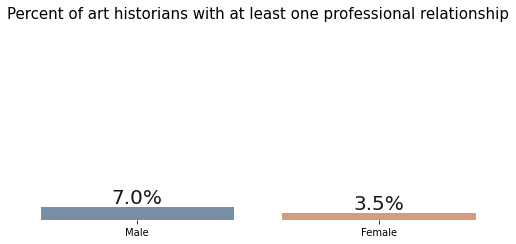

In [58]:
#makeing a bar graph
frequencies = [fm_prof, ff_prof]

plt.figure()

p1 = plt.bar(np.arange(len(frequencies)), frequencies)

# code
import numpy as np
import matplotlib.pyplot as plt

 
# Marks of RAM in different subjects out of 100.
x = ['Male', 'Female']
y = [fm_prof, ff_prof ]
c= c = ["#788ea3", "#d49c7f"]
  
p1 = plt.bar(x, y, color=c)

plt.title("Percent of art historians with at least one professional relationship", fontsize=15)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate( "{}%".format(height),(rect1.get_x() + rect1.get_width()/2, height),ha="center",va="bottom", fontsize=20, color="#191616")

plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['left'].set_color('none')
plt.gca().spines['bottom'].set_color('none')
plt.ylim(0, 100)

plt.yticks([])
plt.savefig('per_prof_rel.png')


Then we wanted to analyze the properties more deeply, just as we did with family relationships. 

First we prepared the dataframe.

In [59]:
#add percent column to analyze subgroup of those with at least one of these relationships declared, like persona relationships

with open('prof_relationships.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['Relationship', 'Gender','Count'])
    for result in results ["results"]["bindings"]:
        my_writer.writerow([result["propertyLabel"]["value"], result["genderLabel"]["value"], result["count"]["value"].strip()])
        
# parse the csv into a dataframe
df = pd.read_csv("prof_relationships.csv")

props_list = df.Relationship.unique().tolist()

#There was the same issue with the next block of code only wanting to run in groups of three so I added two blank rows
df.loc[df.shape[0]] = [None, None, None]
df.loc[df.shape[0]] = [None, None, None]
print(df.head(10))


       Relationship  Gender Count
0  doctoral advisor    male   167
1  doctoral advisor  female   101
2  doctoral student    male   154
3  doctoral student  female    28
4           student    male   216
5           student  female    14
6        student of    male   284
7        student of  female    63
8              None    None  None
9              None    None  None


In [60]:
#always run preceeding cell first
percent_list_m = []
percent_list_f = []
props_list = []

percent_list = []

i=0
#There was the same issue with the next block of code only wanting to run in groups of three hence why this is repeated three times
for row in df: #adds first 3 rows
    if df.at[i, 'Gender']=="female":
        percent_list.append(round(df.at[i,'Count']/f_prof*100))     
        i = i+1
                     
    if df.at[i, 'Gender']=="male":
        percent_list.append(round(df.at[i,'Count']/m_prof*100))
        i = i+1 
for row in df: #adds first 3 rows
    if df.at[i, 'Gender']=="female":
        percent_list.append(round(df.at[i,'Count']/f_prof*100))     
        i = i+1
                     
    if df.at[i, 'Gender']=="male":
        percent_list.append(round(df.at[i,'Count']/m_prof*100))
        i = i+1 

for row in df: #adds first 3 rows
    if df.at[i, 'Gender']=="female":
        percent_list.append(round(df.at[i,'Count']/f_prof*100))     
        i = i+1
                     
    if df.at[i, 'Gender']=="male":
        percent_list.append(round(df.at[i,'Count']/m_prof*100))
        i = i+1 
        
        
df=df.drop([8]) 
df=df.drop([9])

df["percent"]=percent_list

df.head(10)
      




,Relationship,Gender,Count,percent
0,doctoral advisor,male,167,20
1,doctoral advisor,female,101,49
2,doctoral student,male,154,19
3,doctoral student,female,28,14
4,student,male,216,26
5,student,female,14,7
6,student of,male,284,35
7,student of,female,63,31


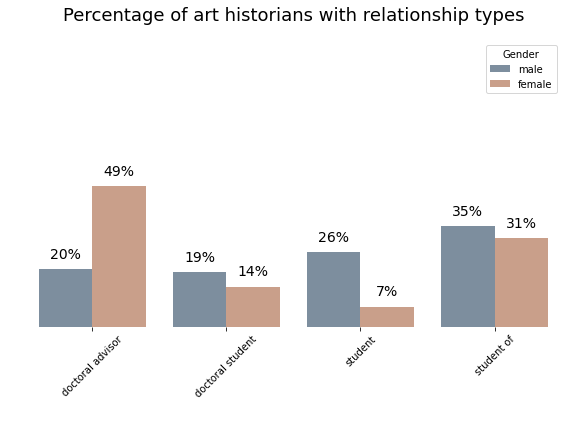

In [64]:
#always run preceding 2 cells first
  
# Importing the dataset
data_df = df
palette = {'male': "#788ea3", 'female': "#d49c7f"}

# code to plot a simple grouped barplot
plt.figure(figsize=(8, 6))
splot = sns.barplot(x="Relationship", y="percent", hue="Gender",
                    data=data_df, palette= palette)
  
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = 20  # pad is in points...

plt.ylabel("Percent", size=14, color="none")
plt.xlabel("Relationship", size=14, color="none")
title=plt.title("Percentage of art historians with relationship types", size=18)
plt.gca().spines['bottom'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['left'].set_color('none')
plt.yticks([])

plt.xticks(rotation=45)
for p in splot.patches:
    splot.annotate(format(round(p.get_height()), '.0f')+"%",
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   size=14,
                   xytext=(0, 15),
                   textcoords='offset points')
  

plt.ylim(0, 100)
plt.savefig('percent_profs.png')
